# Kaggle - Titanic
**Author: David Deschatelets**

In [1]:
# importing required libraries

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# Importing data and preliminary analysis

In [2]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')

First, let's display the first 5 rows of the train dataframe

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I notice that there are 12 columns, 11 features and the 1 dependent variable "Survived".
Now, let's gather a little more information on the train data.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


I notice that I have missing data for some of the features (i.e. Age, Cabin and Embarked). These will need to be filled in later.  

I will create a dataframe containing useful information pertaining to each variable for visual purposes.

In [5]:
data_dict = pd.DataFrame({'Variable': ('survival','pclass','sex','Age','sibsp',
                                       'parch','ticket','fare','cabin','embarked'),
                          'Definition': ('Survival','Ticket class','Sex','Age in years',
                                         '# siblings/spouses aboard','# of parents aboard','Ticket number',
                                         'Passenger fare','Cabin number','Port of Embarkation'),
                          'Key':('0 = No, 1 = Yes', '1 = 1st, 2 = 2nd, 3 = 3rd','','','','','','',
                                 '','C = Cherbourg, Q = Queenstown, S = Southampton')})
data_dict = data_dict.set_index('Variable')
data_dict


,Definition,Key
Variable,,
survival,Survival,"0 = No, 1 = Yes"
pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
sex,Sex,
Age,Age in years,
sibsp,# siblings/spouses aboard,
parch,# of parents aboard,
ticket,Ticket number,
fare,Passenger fare,
cabin,Cabin number,


Now, let's take a look at the test dataframe the same way I did for the train dataframe.

In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


At first glance, I notice that the "Survived" data column has been removed compared to the train dataframe. This is to be expected as it is the dependent variable to be predicted.

Some data are missing in the following categories: Age, Fare, Cabin.

# Data visualization

Let's take a closer at how the survival of the passengers is correlated with the available variables.

In [8]:
# Age and sex

In [9]:
pct_female_survived = train.loc[train['Sex'] == 'female','Survived'].sum() / len(train[train['Sex'] == 'female']) * 100
print('Survival rate is',int(pct_female_survived), '%','if women')

Survival rate is 74 % if women


In [10]:
pct_male_survived = train.loc[train['Sex'] == 'male','Survived'].sum() / len(train[train['Sex'] == 'male']) * 100
print('Survival rate is',int(pct_male_survived), '%','if men')


Survival rate is 18 % if men


First of all, I notice that women are way more likely to survive than men. This is an important feature that I will be keeping for the analysis.

Let's see how the age factor influences the survival rate of the individuals.

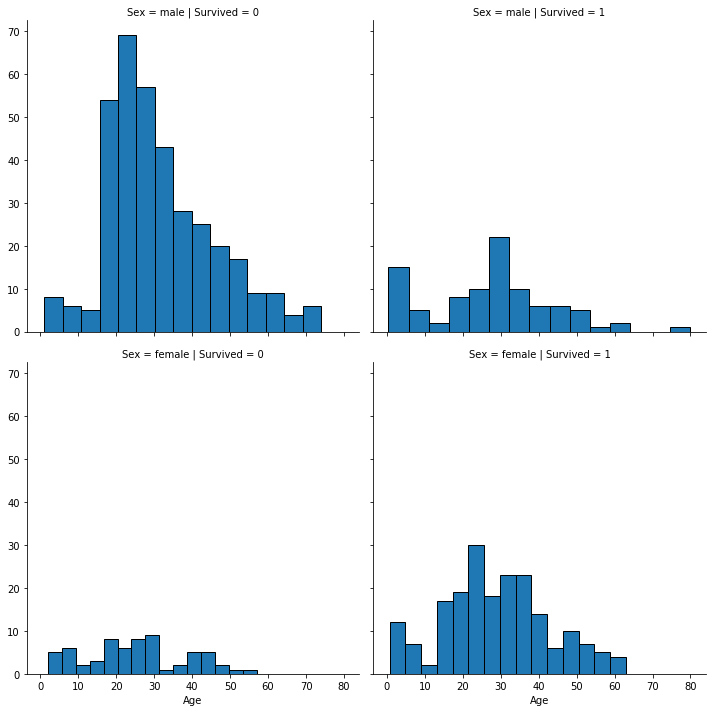

In [11]:
fg_age_sex_survived = sns.FacetGrid(train, row = 'Sex', col = 'Survived', height = 5)
fg_age_sex_survived.map(plt.hist,'Age', bins = 15, edgecolor = 'black')

These plots show a lot of information. I previously showed that women are more likely to survive than men. However, I see here that survival rate is somewhat correlated with age. A good portion of men between 20 and 30 years of age did not survive. Proportionally, we can see that a great portion of male who did survive were youngsters and also men around 30 years of age.  The latter somewhat contradicts the fact that a great portion of men who did not survive also happened to be this age. It is possible that these young men who survived had a family aboard the Titanic, which tipped the scales in their favor. For now, I will keep 'age' as a possible feature. 

In [12]:
# Pclass

Let's take a look at the survival rate according to the Pclass

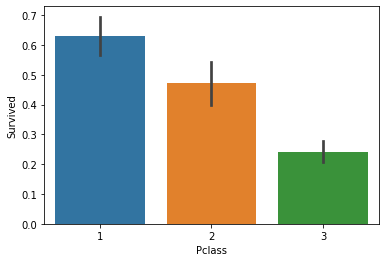

In [13]:
pclass_ax = sns.barplot(x='Pclass', y='Survived', data=train)

There is a clear correlation. Passengers in Pclass 1 are more likely to survive than the others. I will keep this feature in the dataframe

In [14]:
# Name and title

There are 891 different entries in the 'Name' category. Intuitively, this should probably be dropped out from the features list. However, it is possible to extract the title of each individual from the names to obtain information with far less unique values. Let's do this for both the train and test datasets.

In [15]:
all_data = [train, test]
for data in all_data:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)

In the following axis, I plot the survival rate as a function of the unique title values obtained for the train dataset.

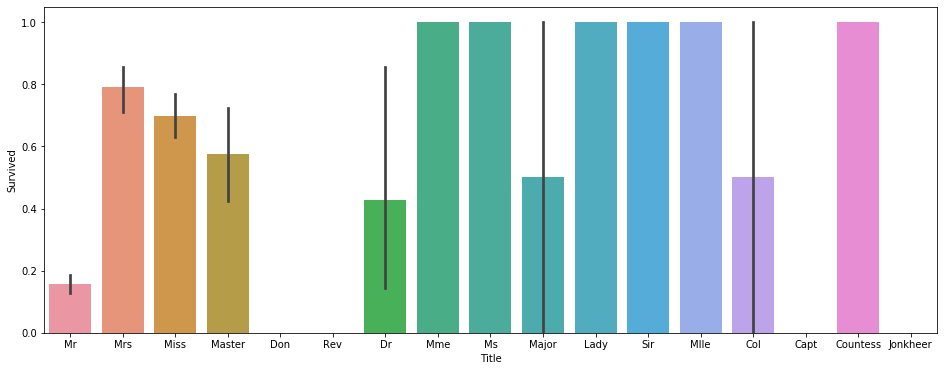

In [16]:
title_ax = sns.barplot(x='Title', y='Survived', data=train)
title_fig = plt.gcf()
title_fig.set_size_inches(16,6)

What I believe is important to retain as information here is the fact that most of the titles pertaining to females have far better survival rate than those related to males. This is in agreement with the analysis carried out for the 'Sex' variable.

It can be seen in the next two lines that there are still quite a few unique values for the new 'Title' feature and its composition is unbalanced for both the train et test datasets.

In [17]:
train.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Mme           1
Ms            1
Capt          1
Jonkheer      1
Countess      1
Lady          1
Sir           1
Don           1
Name: Title, dtype: int64

In [18]:
test.Title.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Ms          1
Dona        1
Name: Title, dtype: int64

I will keep the 'Title' feature for now and map its components into fewer entries later on. As I don't need the name feature anymore, I will drop it from the datasets.

In [19]:
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

In [20]:
# Siblings and family

My hypothesis is that there is a correlation between survival rate and whether a certain individual has family or not. I will combine the 'sibsp' and 'parch' together. I will then return a boolean 1 if an individual has sibsp + parch > 1 and 0 otherwise under a new 'Family' column.

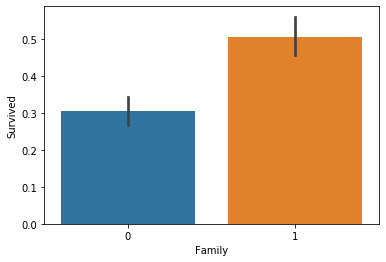

In [21]:
all_data = [train, test]
for data in all_data:
    data['Family'] = data['SibSp'] + data['Parch']
    data.loc[data['Family'] > 0, 'Family'] = 1
    
    
family_ax = sns.barplot(x='Family', y='Survived', data=train)

As predicted, there does seem to be a correlation between the survival rate and whether the individual had family or not aboard the Titanic. I will keep 'Family' as a feature and drop 'SibSp' and 'Parch'.

In [22]:
train = train.drop(['SibSp','Parch'], axis = 1)
test = test.drop(['SibSp','Parch'], axis = 1)

In [23]:
# Fare

I think it would be intuitive to think that people who paid a higher fare are more likely to be given priority for lifeboats.

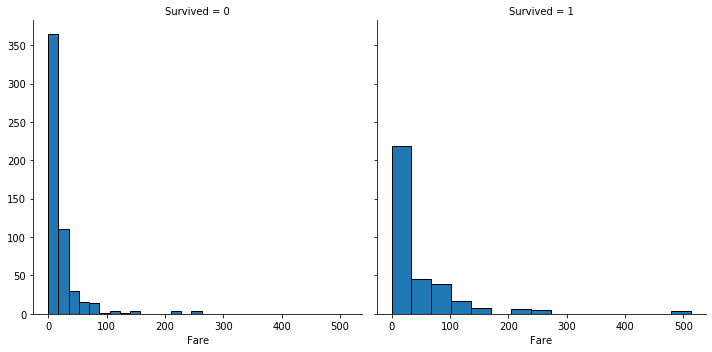

In [24]:
fg_fare_survived = sns.FacetGrid(train, col = 'Survived', height = 5)
fg_fare_survived.map(plt.hist,'Fare', bins = 15, edgecolor = 'black')

I see that there is proportionally a greater chance of survival if the fare is higher.

Let's make sure of this with a quick quantitative analysis.

In [25]:
pct_high_fare_survived = train.loc[train['Fare'] >= 10,'Survived'].sum() / len(train[train['Fare'] >= 10]) * 100
print('Survival rate is',int(pct_high_fare_survived), '%','if Fare >= 10')

Survival rate is 49 % if Fare >= 10


In [26]:
pct_low_fare_survived = train.loc[train['Fare'] < 10,'Survived'].sum() / len(train[train['Fare'] < 10]) * 100
print('Survival rate is',int(pct_low_fare_survived), '%', 'if Fare < 10')

Survival rate is 19 % if Fare < 10


This shows that an individual is about 2.5x more likely to have survived if his/her fare was greater than or equal to 10 as opposed to if his/her fare was less than 10. I will keep this feature for the analysis.

In [27]:
# Embarked

Let's see if the port of embarkation had any impact on the survival rate.

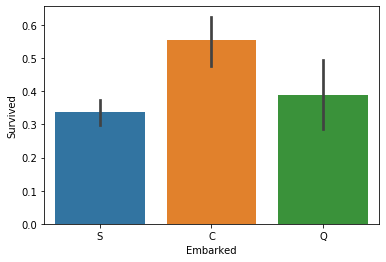

In [28]:
pclass_ax = sns.barplot(x='Embarked', y='Survived', data=train)

I note that people who embarked at port C seems to have had a better survival rate. This is useful information and I will keep this feature for the analysis.

In [29]:
# Cabin

Let's recall that only 204 entries out of 891 are available for the 'Cabin' variable.

In [30]:
len(train.Cabin.dropna().unique())

147

Moreover, out of these 204 entries, 147 are unique. This is problematic. I will group these values into fewer categories by keeping only the first character from the strings. This will facilitate the visual representation of the data.

In [31]:
train.Cabin.str[0].dropna().unique()

array(['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [32]:
all_data = [train, test]
for data in all_data:  
    data['Cabin'] = data['Cabin'].str[0]

In [33]:
train['Cabin'].head()

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Cabin, dtype: object

The following axis is the survival rate as a function of the cabin "section" of the individuals.

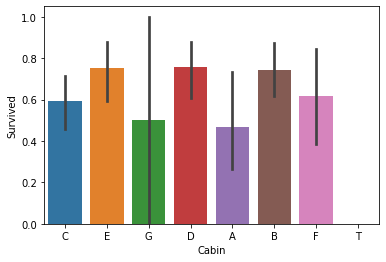

In [34]:
pclass_ax = sns.barplot(x='Cabin', y='Survived', data=train)

I see that there seems to be a small correlation between the survival rate and the cabin sections. I predict that this feature will not contribute much to the accuracy of the models but I will keep it for the analysis.

In [35]:
# Passenger ID and ticket

'Passenger Id' is simply composed of incrementing numbers and I don't see how this could be somehow correlated with survival rate.

In [36]:
train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
347088      6
3101295     6
           ..
12460       1
315090      1
2926        1
19947       1
349225      1
Name: Ticket, Length: 681, dtype: int64

I see that the most frequent 'Ticket' value is 7. 'Ticket' contains too many different entries to be grouped into something containing useful information.

Therefore, I will drop 'Ticket' from the train and test datasets. I will also drop 'PassengerId' from the train dataset but keep it for the test dataset as I will need it later on when submitting my predictions.

In [37]:
train = train.drop(['PassengerId'], axis = 1)
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

Let's display what the train dataset looks like so far.

In [38]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,male,22.0,7.2500,NaN,S,Mr,1
1,1,1,female,38.0,71.2833,C,C,Mrs,1
2,1,3,female,26.0,7.9250,NaN,S,Miss,0
3,1,1,female,35.0,53.1000,C,S,Mrs,1
4,0,3,male,35.0,8.0500,NaN,S,Mr,0


# Feature engineering

In [39]:
# Sex

'Sex' category has no null values for both the train and test datasets. I will simply map the entries to integers.

In [40]:
sex_map = {'male' : 0, 'female' : 1}
all_data = [train, test]

for data in all_data:
    data['Sex'] = data['Sex'].map(sex_map)

In [41]:
# Age

'Age' category has missing values for both datasets. There are many possible ways to impute missing datas. I will use a simple forward fill to propagate the last valid observation forward.

In [42]:
all_data = [train, test]
for data in all_data:
    data['Age'] = data['Age'].ffill(axis = 0)


'Age' values spans over a great scale of numbers. Later on, I will be using models which works on the principle of Euclidean distance to make the predictions. Keeping number of this size will have a negative impact on some of the model I will use. Therefore, I will separate the data based on quantiles to obtain buckets of similar sizes.

In [43]:
age_class = pd.qcut(train['Age'], 5, labels = False, retbins = True)
age_bracket = list(np.round(age_class[1]).astype(int))
age_bracket

[0, 19, 25, 32, 41, 80]

I display the age brackets and use them to assign an integer to each age interval.

In [44]:
all_data = [train, test]
for data in all_data:
    data.loc[data['Age'] <= 19, 'Age'] = 0
    data.loc[(data['Age'] > 19) & (data['Age'] <= 25), 'Age'] = 1
    data.loc[(data['Age'] > 25) & (data['Age'] <= 32), 'Age'] = 2
    data.loc[(data['Age'] > 32) & (data['Age'] <= 41), 'Age'] = 3
    data.loc[data['Age'] > 41, 'Age'] = 4   

I check that each age group is similar in size to make sure that none of them is overrepresented in the data.

In [45]:
train['Age'].value_counts()

0.0    211
4.0    176
2.0    173
1.0    167
3.0    164
Name: Age, dtype: int64

In [46]:
# Cabin

First, I assign an integer to each unique entries.

In [47]:
cabin = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7, 'T' : 8}

In [48]:
all_data = [train, test]
for data in all_data:    
    data['Cabin'] = data['Cabin'].map(cabin)  

Then, I will replace the missing values of each dataset with their mean value for this particular category.

In [49]:
train['Cabin'].fillna(train['Cabin'].mean(), inplace = True)
test['Cabin'].fillna(test['Cabin'].mean(), inplace = True)

I convert all entries to an integer to remove the decimals of the mean values.

In [50]:
train['Cabin'] = train['Cabin'].astype(int)
test['Cabin'] = test['Cabin'].astype(int)

In [51]:
# Fare

I will use a strategy similar to the one I used previously to fill in the missing values of 'Fare'.

In [52]:
all_data = [train, test]
for data in all_data:
    data['Fare'] = data['Fare'].ffill(axis = 0)

Then, I will decompose this category into quantiles like I did before for 'Age' and assign an integer to each of these intervals.

In [53]:
fare_class = pd.qcut(train['Fare'], 5, labels = False, retbins = True)
fare_bracket = list(np.round(fare_class[1]).astype(int))
fare_bracket

[0, 8, 10, 22, 40, 512]

In [54]:
all_data = [train, test]
for data in all_data:
    data.loc[data['Fare'] <= 8, 'Fare'] = 0
    data.loc[(data['Fare'] > 8) & (data['Fare'] <= 10), 'Fare'] = 1
    data.loc[(data['Fare'] > 10) & (data['Fare'] <= 22), 'Fare'] = 2
    data.loc[(data['Fare'] > 22) & (data['Fare'] <= 40), 'Fare'] = 3
    data.loc[data['Fare'] > 40, 'Fare'] = 4   

In [55]:
train['Fare'].value_counts()

0.0    241
2.0    199
3.0    180
4.0    176
1.0     95
Name: Fare, dtype: int64

In [56]:
# Embarked

At this point, I am making sure I don't have any more missing values

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Cabin     891 non-null    int32  
 6   Embarked  889 non-null    object 
 7   Title     891 non-null    object 
 8   Family    891 non-null    int64  
dtypes: float64(2), int32(1), int64(4), object(2)
memory usage: 59.3+ KB


In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   Fare         418 non-null    float64
 5   Cabin        418 non-null    int32  
 6   Embarked     418 non-null    object 
 7   Title        418 non-null    object 
 8   Family       418 non-null    int64  
dtypes: float64(2), int32(1), int64(4), object(2)
memory usage: 27.9+ KB


The only category missing some values for the train dataset is 'Embarked'. Let's count how many entries there are per port.

In [59]:
print('S:',train.loc[train['Embarked'] == 'S', 'Embarked'].count())
print('C:',train.loc[train['Embarked'] == 'C', 'Embarked'].count())
print('Q:',train.loc[train['Embarked'] == 'Q', 'Embarked'].count())

S: 644
C: 168
Q: 77


Because there is a far greater amount of 'S' embarkations compared to the other ports, I will fill in the remainder of the missing values with the 'S' port.

In [60]:
all_data = [train, test]
for data in all_data:
    data['Embarked'] = data['Embarked'].fillna('S')

Now, let's assign each port of embarkation to an integer.

In [61]:
embarked_map = {'S' : 0, 'C' : 1, 'Q' : 2}

all_data = [train, test]

for data in all_data:
    data['Embarked'] = data['Embarked'].map(embarked_map)

In [62]:
# Title

Finally, for the 'Title' category, I will assign the integers 0 to 3 for the four bigger groups and the integer 4 for the rest of the smaller groups.

In [63]:
title_map = {'Mr' : 0, 'Miss' : 1, 'Mrs' : 2, 'Master' : 3,
             'Dr' : 4, 'Rev' : 4, 'Mlle' : 4, 'Major' : 4,
             'Col' : 4, 'Mme' : 4, 'Capt' : 4, 'Jonkheer' : 4,
             'Lady' : 4, 'Countess' : 4, 'Don' : 4, 'Sir' : 4,
             'Ms' : 4, 'Dona' : 4}             

all_data = [train, test]
for data in all_data:
    data['Title'] = data['Title'].map(title_map)

I should now be ready to test the different models. I make sure one last time that I don't have anymore missing values and display the first rows of the train dataset.

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Cabin     891 non-null    int32  
 6   Embarked  891 non-null    int64  
 7   Title     891 non-null    int64  
 8   Family    891 non-null    int64  
dtypes: float64(2), int32(1), int64(6)
memory usage: 59.3 KB


In [65]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   Fare         418 non-null    float64
 5   Cabin        418 non-null    int32  
 6   Embarked     418 non-null    int64  
 7   Title        418 non-null    int64  
 8   Family       418 non-null    int64  
dtypes: float64(2), int32(1), int64(6)
memory usage: 27.9 KB


In [66]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,0,1.0,0.0,3,0,0,1
1,1,1,1,3.0,4.0,3,1,2,1
2,1,3,1,2.0,0.0,3,0,1,0
3,1,1,1,3.0,4.0,3,0,2,1
4,0,3,0,3.0,1.0,3,0,0,0


# Testing different models

First, I separate the dependent 'response' variable from the train dataset.

In [67]:
train_y = train['Survived']

In [68]:
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Then, I drop the 'Survived' variable from the train features dataset.

In [69]:
train_x = train.drop('Survived', axis = 1)
train_x

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,3,0,1.0,0.0,3,0,0,1
1,1,1,3.0,4.0,3,1,2,1
2,3,1,2.0,0.0,3,0,1,0
3,1,1,3.0,4.0,3,0,2,1
4,3,0,3.0,1.0,3,0,0,0
...,...,...,...,...,...,...,...,...
886,2,0,2.0,2.0,3,0,4,0
887,1,1,0.0,3.0,2,0,1,0
888,3,1,0.0,3.0,3,0,1,1
889,1,0,2.0,3.0,3,1,0,0


I create a new test_x features dataframe from which I drop the 'PassengerId' variable.

In [70]:
test_x = test.drop(['PassengerId'], axis = 1)

In all, I will be testing 5 different models. For all models, I use a 10-fold cross validation and display both the cross-validation mean and standard deviation score values.

In [71]:
# Random Forest

I tried different n_estimators values for this model and found '60' to be a good value according to the different performance metrics.

In [72]:
rf = RandomForestClassifier(n_estimators = 60)

cross_val = cross_val_score(rf, train_x, train_y, cv=10, scoring ='accuracy')

predict = cross_val_predict(rf, train_x, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())


cross val mean: 0.8092759051186018
cross val std: 0.04591535758328741


In [73]:
# SVM

All parameters are set to default.

In [74]:
svm = SVC()

cross_val = cross_val_score(svm, train_x, train_y, cv=10, scoring ='accuracy')

predict = cross_val_predict(svm, train_x, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())

cross val mean: 0.8271660424469414
cross val std: 0.03448817993343092


In [75]:
# K nearest neighbors

n_neighbors = 5 gave me the best results.

In [76]:
knn = KNeighborsClassifier(n_neighbors = 5)

cross_val = cross_val_score(knn, train_x, train_y, cv=10, scoring ='accuracy')
                           
predict = cross_val_predict(knn, train_x, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())

cross val mean: 0.8183021223470662
cross val std: 0.054585570512076576


In [77]:
# Logistic regression

All parameters are set to default.

In [78]:
lr = LogisticRegression()

cross_val = cross_val_score(lr, train_x, train_y, cv=10, scoring ='accuracy')

predict = cross_val_predict(lr, train_x, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())

cross val mean: 0.7957802746566791
cross val std: 0.03756843689960243


In [79]:
# Decision tree

All parameters are set to default.

In [80]:
dt = DecisionTreeClassifier()

cross_val = cross_val_score(dt, train_x, train_y, cv=10, scoring ='accuracy')

predict = cross_val_predict(dt, train_x, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())

cross val mean: 0.8036579275905117
cross val std: 0.04920112546435863


According to the performance metrics, the best model to use is the SVM classifier.

# Submitting file

I use the svm model to make the final prediction on the test dataset.

In [81]:
svm.fit(train_x, train_y)
test_y = svm.predict(test_x)

Creating submission_file according to the format presented on Kaggle.

In [82]:
submission_file = pd.DataFrame({'PassengerId' : test['PassengerId'], 'Survived' : test_y})

Sending file to a .csv document

In [83]:
submission_file.to_csv('submission_file_David_Deschatelets.csv', index = False)

# Discussion and additional analyses

The analysis carried out in this document was done in about 4-6 hours to make it representative of what is to be expected when working under a time constraint. As shown in my analysis, I mostly used the model with their default settings. Additional tweakings could have been made to the models to extract a few percentage points, additional performance metrics could also have been implemented to better assess the performance of the models and a more thorough feature analysis could have been carried out to assess their importance in the models. More complex ensemble modeling could also have been used to obtain better results.

With this said, there remains work to be done to push the performance bar further. For instance, I have not considered interaction terms. Features can become greatly correlated with the dependent variable when combined together. I also strongly believe that there is presence of multicollinearity in my features (e.g. Sex and Title). 

Take a look at the following example where I drop the 'Sex' feature from the datasets:

In [84]:
train_x2 = train_x.copy()
test_x2 = test_x.copy()

train_x2 = train_x2.drop(['Sex'], axis = 1)
test_x2 = test_x2.drop(['Sex'], axis = 1)

In [85]:
# SVM

In [86]:
svm = SVC()

cross_val = cross_val_score(svm, train_x2, train_y, cv=10, scoring ='accuracy')

predict = cross_val_predict(svm, train_x2, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())

cross val mean: 0.8181897627965045
cross val std: 0.03848702332454936


Dropping in turn the features 'Sex' and 'Title' individually does not impact considerably the performance of the SVM model. This is because a lot of information related to 'Sex' can be found in 'Title' (e.g. Mrs. = female, Miss. = female, Mr. = male, etc.)

However, notice how badly the performance is impacted when both of these features are dropped from the features list.

In [87]:
train_x3 = train_x.copy()
test_x3 = test_x.copy()

train_x3 = train_x3.drop(['Sex','Title'], axis = 1)
test_x3 = test_x3.drop(['Sex', 'Title'], axis = 1)

In [88]:
# SVM

In [89]:
svm = SVC()

cross_val = cross_val_score(svm, train_x3, train_y, cv=10, scoring ='accuracy')

predict = cross_val_predict(svm, train_x3, train_y, cv=10)

print('cross val mean:',cross_val.mean())
print('cross val std:', cross_val.std())

cross val mean: 0.6959300873907617
cross val std: 0.05171165809340027
